In [1]:
import pandas as pd
from notebooks.consts import *

all_data = pd.read_csv(str(ORIGINAL_CSV), low_memory=False)

In [2]:
gene_to_canonical = {
    "K-RAS" : "KRAS",
    "YAP1" : "YAP1",
    "PKK" : "KLKB1",
    "SNCA_LNA" : "SNCA",
    "ANGPTL2_LNA" : "ANGPTL2",
    "TAU" : "MAPT",
    "SOD-1" : "SOD1",
}

# Apply the mapping; if key is missing, map returns NaN, so we fill with original values
all_data['Target_gene'] = all_data['Target_gene'].str.upper()
all_data[CANONICAL_GENE] = all_data['Target_gene'].map(gene_to_canonical).fillna(all_data['Target_gene'])

In [3]:
all_data['true_length_of_seq'] = all_data[SEQUENCE].str.len()

In [4]:
HUMAN = 'human'
MONKEY = 'monkey'
MOUSE = 'mouse'
UNKNOWN = 'unknown'

cell_line_to_organism = {
    # --- Human ---
    'A431': HUMAN,
    'A-431' : HUMAN,
    'Angptl2/Actin': HUMAN,
    'CC-2580': HUMAN,
    'H929': HUMAN,
    'Hela': HUMAN,
    'HepG2': HUMAN,
    'HepaRG': HUMAN,
    'Human IPS': HUMAN,
    'Human Neuronal Cell': HUMAN,
    'KARPAS-229': HUMAN,
    'KMS11': HUMAN,
    'MM.1R': HUMAN,
    'NCI-H460': HUMAN,
    'PAC neurons asyn': HUMAN,
    'SH-SY5Y': HUMAN,
    'SK cells asyn': HUMAN,
    'SK-MEL-28': HUMAN,
    'SNU-449': HUMAN,
    'U251': HUMAN,

    # --- Mouse ---
    'Mouse Primary Neuronal Cell': MOUSE,
    'Oscillation': MOUSE,
    'Tubulin': MOUSE,

    # --- Monkey ---
    'LLC-MK2 monkey': MONKEY, # Green Monkey
}

In [5]:
all_data[CELL_LINE_ORGANISM] = all_data[CELL_LINE].map(cell_line_to_organism)

In [6]:
data_length = len(all_data)
data_length

36890

In [7]:
# Missing Inhibition
filtered_data = all_data[~all_data[INHIBITION].isna()]
remaining_data = len(filtered_data)
print(f"Removed: {data_length - remaining_data} remained {remaining_data}")

Removed: 2125 remained 34765


In [8]:
# Non-human cell lines

# Check to see we didn't miss anything
missing_organisms = all_data[all_data[CELL_LINE_ORGANISM].isna()][CELL_LINE].unique()
print(f"Cell lines being dropped as 'Unknown': {missing_organisms}")

data_length = remaining_data

filtered_data = filtered_data[filtered_data[CELL_LINE_ORGANISM] == 'human']
remaining_data = len(filtered_data)
print(f"Removed: {data_length - remaining_data} remained {remaining_data}")

Cell lines being dropped as 'Unknown': []
Removed: 1040 remained 33725


In [9]:
# Average inhibition numbers to avoid repetitive
ISIS = 'ISIS'
LINKAGE = 'Linkage'
LINKAGE_LOCATION = 'Linkage_Location'
TARGET_GENE = 'Target_gene'

In [10]:
# Non-human cell lines
data_length = remaining_data

filtered_data = filtered_data[filtered_data[LINKAGE] == 'phosphorothioate']
remaining_data = len(filtered_data)
print(f"Removed: {data_length - remaining_data} remained {remaining_data}")

Removed: 2491 remained 31234


In [11]:
# Non-human cell lines
data_length = remaining_data

filtered_data = filtered_data[filtered_data[TARGET_GENE] != 'NEGATIVE_CONTROL']
remaining_data = len(filtered_data)
print(f"Removed: {data_length - remaining_data} remained {remaining_data}")

Removed: 2 remained 31232


In [12]:
# Averaging identical experiments

group_cols = [ISIS, TRANSFECTION, LINKAGE, LINKAGE_LOCATION, DENSITY, PRIMER_PROBE, CANONICAL_GENE, CELL_LINE, VOLUME, TREATMENT_PERIOD, SEQUENCE, MODIFICATION, CHEMICAL_PATTERN]

aggregated_data = filtered_data.groupby(group_cols, dropna=False).agg({
    INHIBITION: ['mean', 'std', 'count']
}).reset_index()

aggregated_data.columns = group_cols + ['mean_inhibition', 'std_inhibition', 'replicate_count']
aggregated_data['std_inhibition'] = aggregated_data['std_inhibition'].fillna(0)

In [13]:
remaining_data = len(aggregated_data)
print(f"Removed: {data_length - remaining_data} remained {remaining_data}")
filtered_data = aggregated_data

Removed: 2929 remained 28305


In [14]:
# Cross-probe aggregation: Average the results where the only difference is the probe used
# We remove PRIMER_PROBE from the grouping criteria
group_cols_cross_probe = [ISIS, TRANSFECTION, LINKAGE, LINKAGE_LOCATION, DENSITY, CANONICAL_GENE, CELL_LINE, VOLUME, TREATMENT_PERIOD, SEQUENCE, MODIFICATION, CHEMICAL_PATTERN]

data_length = len(filtered_data)

aggregated_cross_probe = filtered_data.groupby(group_cols_cross_probe, dropna=False).agg({
    'mean_inhibition': ['mean', 'std', 'count'],
    'replicate_count': 'sum'
}).reset_index()

# Rename columns to reflect the hierarchy
aggregated_cross_probe.columns = group_cols_cross_probe + ['mean_inhibition', 'probe_std', 'probe_count', 'total_replicate_count']

# Fill std with 0 for experiments that only used one probe
aggregated_cross_probe['probe_std'] = aggregated_cross_probe['probe_std'].fillna(0)

remaining_data = len(aggregated_cross_probe)
print(f"Removed (Cross-probe merge): {data_length - remaining_data} remained {remaining_data}")

filtered_data = aggregated_cross_probe

Removed (Cross-probe merge): 1130 remained 27175


In [15]:
# We average results where the only difference is the Cell Density
# We remove DENSITY from the grouping criteria
group_cols_final = [ISIS, TRANSFECTION, LINKAGE, LINKAGE_LOCATION, CANONICAL_GENE, CELL_LINE, VOLUME, TREATMENT_PERIOD, SEQUENCE, MODIFICATION, CHEMICAL_PATTERN]

data_length = len(filtered_data)

# Aggregate across densities
final_consensus_data = filtered_data.groupby(group_cols_final, dropna=False).agg({
    'mean_inhibition': 'mean',
    'probe_std': 'mean',          # Average the probe variance
    'probe_count': 'sum',         # Total number of probes used across all densities
    'total_replicate_count': 'sum'# Total raw measurements
}).reset_index()

remaining_data = len(final_consensus_data)
print(f"Removed (Density merge): {data_length - remaining_data} remained {remaining_data}")

# Rename target for clarity
final_consensus_data = final_consensus_data.rename(columns={'mean_inhibition': 'target_inhibition'})

filtered_data = final_consensus_data

Removed (Density merge): 96 remained 27079


In [16]:
cache = filtered_data.copy()

In [17]:
filtered_data[MODIFICATION].unique()

array(['LNA/deoxy', 'cEt/5-methylcytosines/deoxy',
       'MOE/5-methylcytosines/deoxy', '(S)-cEt/5-methylcytosines/deoxy',
       'MOE/(S)-cEt/5-methylcytosines/deoxy', '5-methylcytosines/deoxy',
       'MOE/cEt/5-methylcytosines/deoxy',
       '(S)-cEt/5-methylcytosines/MOE/deoxy',
       'cEt/o-methylribose/5-methylcytosines/deoxy',
       'MOE/cEt/o-methylribose/5-methylcytosines/deoxy', 'LNA/OMe/deoxy'],
      dtype=object)

In [18]:
# We drop all mixed chemistries, because it will skew the algorithm. We dropped th epure 5'-methylcytosines/deoxy because of too few samples and low inhibition.

data_length = remaining_data

filtered_data = filtered_data[filtered_data[MODIFICATION].isin(
    ['cEt/5-methylcytosines/deoxy', 'MOE/5-methylcytosines/deoxy', '(S)-cEt/5-methylcytosines/deoxy', 'LNA/deoxy'])]
remaining_data = len(filtered_data)
print(f"Removed: {data_length - remaining_data} remained {remaining_data}")

Removed: 6930 remained 20149


In [19]:
# --- Refined Modification Scan Analysis & Filtering ---

filtered_data['Cohort'] = filtered_data[CANONICAL_GENE] + " (" + filtered_data[CELL_LINE] + ")"

# 2. Calculate Unique Molecular Designs (Sequence + Modification + Pattern)
# We ignore Volume and Treatment Period in this count to isolate chemistry scans.
unique_designs_df = filtered_data.groupby(['Cohort', SEQUENCE, MODIFICATION, CHEMICAL_PATTERN, LINKAGE, LINKAGE_LOCATION]).size().reset_index()
cohort_designs = unique_designs_df.groupby('Cohort').size().to_frame('Unique_Molecular_Designs')

# 3. Calculate Unique Sequences per cohort
cohort_seqs = filtered_data.groupby('Cohort')[SEQUENCE].nunique().to_frame('Unique_Sequences')

# 4. Final Diversity Stats
diversity_stats = cohort_seqs.join(cohort_designs).reset_index()
diversity_stats['Diversity_Ratio'] = diversity_stats['Unique_Sequences'] / diversity_stats['Unique_Molecular_Designs']

# 5. Identify Cohorts to Remove (Threshold = 0.2)
MOD_SCAN_THRESHOLD = 0.2
to_remove = diversity_stats[diversity_stats['Diversity_Ratio'] < MOD_SCAN_THRESHOLD]['Cohort'].tolist()

# 6. Calculate drop statistics
data_before = len(filtered_data)
rows_to_drop = len(filtered_data[filtered_data['Cohort'].isin(to_remove)])
pct_dropped = (rows_to_drop / data_before) * 100

print(f"Removing {len(to_remove)} true modification-scan cohorts: {to_remove}")
print(f"Final Cleaning Result: Removed {rows_to_drop} rows ({pct_dropped:.2f}% of aggregated data).")

# 7. Apply the filter
filtered_data = filtered_data[~filtered_data['Cohort'].isin(to_remove)]
print(f"Remaining data points: {len(filtered_data)}")


Removing 4 true modification-scan cohorts: ['HIF1A (Hela)', 'MYH7 (CC-2580)', 'SNCA (PAC neurons asyn)', 'SNCA (SK cells asyn)']
Final Cleaning Result: Removed 1071 rows (5.32% of aggregated data).
Remaining data points: 19078


/tmp/ipykernel_1347513/3271810656.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Cohort'] = filtered_data[CANONICAL_GENE] + " (" + filtered_data[CELL_LINE] + ")"


/tmp/ipykernel_1347513/514254037.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_data, x='Diversity_Ratio', y='Cohort', palette='viridis')


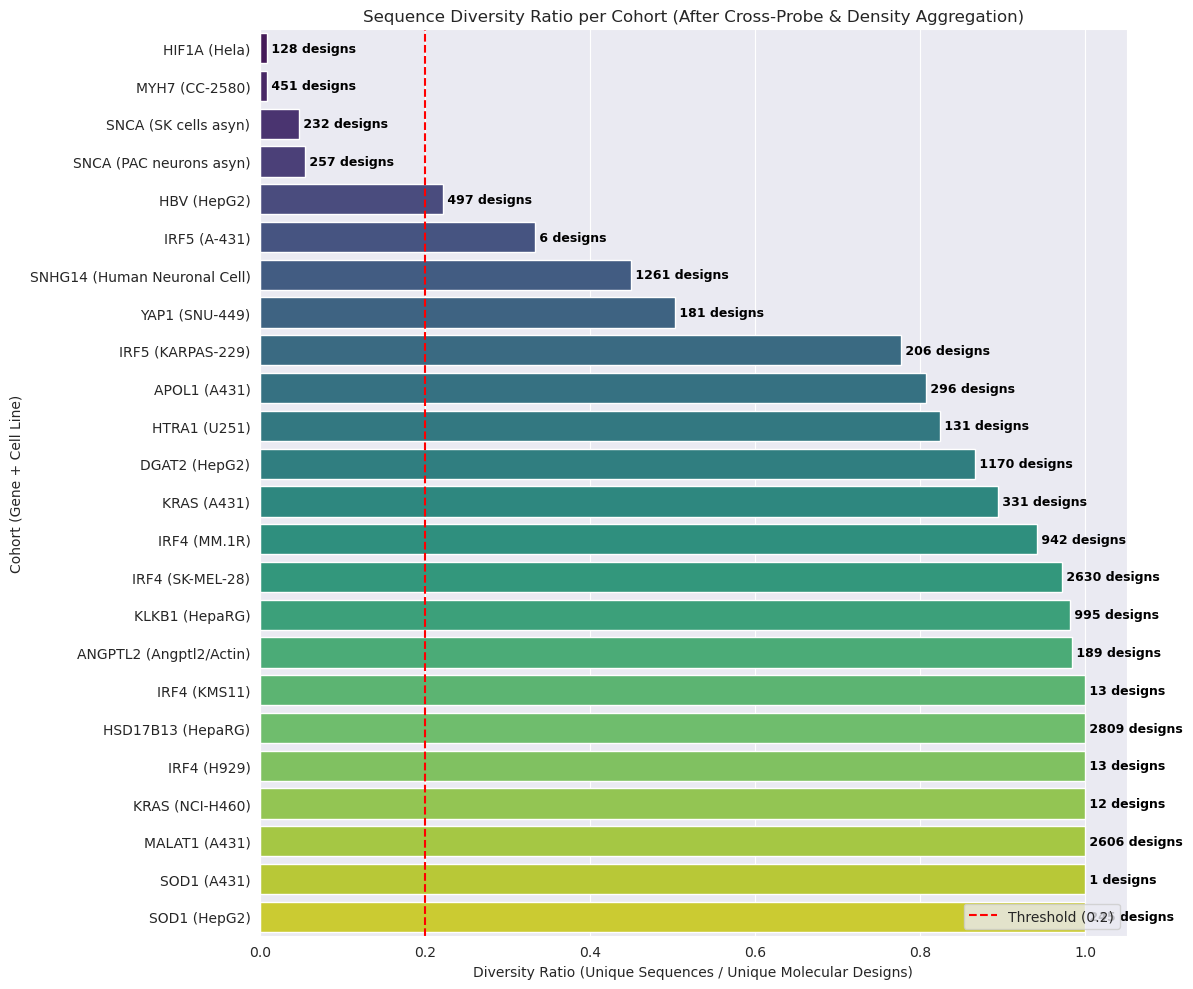

In [20]:
# 8. Plot the Diversity Ratio with Design Counts
import matplotlib.pyplot as plt
import seaborn as sns

plot_data = diversity_stats.sort_values('Diversity_Ratio')
plt.figure(figsize=(12, 10))
ax = sns.barplot(data=plot_data, x='Diversity_Ratio', y='Cohort', palette='viridis')
plt.axvline(x=MOD_SCAN_THRESHOLD, color='red', linestyle='--', label=f'Threshold ({MOD_SCAN_THRESHOLD})')

# Annotate bars with the actual number of unique designs
for i, p in enumerate(ax.patches):
    count = plot_data.iloc[i]['Unique_Molecular_Designs']
    ax.annotate(f" {int(count)} designs",
                (p.get_width(), p.get_y() + p.get_height() / 2),
                va='center', fontsize=9, color='black', fontweight='bold')

plt.title('Sequence Diversity Ratio per Cohort (After Cross-Probe & Density Aggregation)')
plt.xlabel('Diversity Ratio (Unique Sequences / Unique Molecular Designs)')
plt.ylabel('Cohort (Gene + Cell Line)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [21]:
filtered_data.to_csv(PROCESSED_CSV)